# Reinforcement Learning - Projet

This is a notebook that implement Tic Tac Toe game with use of the Monte-Carlo tree search (MCTS) algorithm.
This is part of the Reinforcement Learning course of E. LePennec, professor at École Polytechnique.

Alexis Gerbeaux et Cédric Allain - février 2020

Sources:

    - Tic Tac Toe game: https://gist.github.com/eaorak/3966315
    
    - MCTSPY package: https://pypi.org/project/mctspy/

## Packages

In [1]:
# Set to True if use in Google Colab
use_colab = False

# Set to True if want to save results in Google Drive
use_drive = False

In [2]:
from __future__ import division

import pandas as pd
import numpy as np
import random
import itertools
import sys
import time
from tqdm import tqdm
from collections import Counter
from copy import deepcopy
from functools import reduce
import operator

# MCTSPY 
if use_colab:
    !pip install mctspy
from mctspy.tree.nodes import TwoPlayersGameMonteCarloTreeSearchNode
from mctspy.games.examples.tictactoe import TicTacToeGameState

# Graphes
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [3]:
if use_drive:
    from google.colab import drive
    drive.mount('drive')

## Tic tac toe (jeu du morpion)

In this notebook, we implement a game of Tic Tac Toe.
We create it so 2 automatic players can play together, with different level of difficulty: random, smart and mcts.
We used the following implementation of Tic Tac Toe game, that we adapted to our needs: https://gist.github.com/eaorak/3966315

The level 'mcts' corresponds to the level of difficulty where the player choose its actions based on a Monte-Carle tree search.
Do to so, we use the package mctspy: https://pypi.org/project/mctspy/, with its own TicTacToe example (https://github.com/int8/monte-carlo-tree-search/blob/master/mctspy/games/examples/tictactoe.py)

We also use some of the code in the package MCTS (https://github.com/pbsinclair42/MCTS) and in its Tic Tac Toe implementation (https://github.com/pbsinclair42/MCTS/blob/master/naughtsandcrosses.py)

In [4]:
class TicTacToeState():
    def __init__(self, board=None, first_player=1):
        if board is not None:
            if len(board.shape) != 2 or (board.shape[0] != board.shape[1]):
                raise ValueError("Only 2D square boards allowed")
            else:
                self.board = np.array(board)
        else:
            self.board = np.zeros((3,3))
            
        self.board_size = self.board.shape[0]
        
        if first_player not in [1,-1]:
            raise ValueError("First player must be equal to 1 (player) or -1 (computer).")
        #self.currentPlayer = first_player
        self.next_to_move = first_player
        
        self.corners = [[0,0],
                        [0, self.board_size-1],
                        [self.board_size-1, 0],
                        [self.board_size-1, self.board_size-1]]
        self.center = [int(self.board_size/2), int(self.board_size/2)]
    
    
    def get_legal_actions(self):
        """Given a current state, return all the posssible actions"""
        return [Action(player=self.next_to_move, x=idx[0], y=idx[1])
                for idx in np.argwhere(self.board==0)]


    def move(self, action):
        newState = deepcopy(self)
        newState.board[action.x][action.y] = action.player
        newState.next_to_move = self.next_to_move * -1
        return newState
    
    
    def takeRandomAction(self):
        return self.move(action=random.choice(self.get_legal_actions()))
    
    
    def takeSmartAction(self):
        """ Play a 'smart' action: 
            - win if it can
            - block opponent if it can win next
            - otherwise, play a action following the rule :
                first the corners then the center, otherwise a random available position """
        possible_actions = self.get_legal_actions()
        
        # win if it can
        for action in possible_actions:
            newState = self.move(action)
            if newState.gameResult() == [True, action.player]:
                return self.move(action)
            
        # block opponent if is going to win
        for action in possible_actions:
            actionOpponent = deepcopy(action)
            actionOpponent.player = action.player * -1
            newState = self.move(actionOpponent)
            if newState.gameResult() == [True, actionOpponent.player]:
                return self.move(action)

        # play randomly
        return self.move(action=random.choice(possible_actions))

    
    def gameResult(self):
        for row in self.board:
            if abs(sum(row)) == self.board_size:
                is_terminal = True
                reward = sum(row) / self.board_size
                return [is_terminal, reward]
        
        for column in self.board.T:
            if abs(sum(column)) == self.board_size:
                is_terminal = True
                reward = sum(column) / self.board_size
                return [is_terminal, reward]

        first_diag = self.board.trace()
        second_diag = self.board[::-1].trace()
        
        for diagonal in [first_diag, second_diag]:
            if abs(diagonal) == self.board_size:
                is_terminal = True
                reward = diagonal / self.board_size
                return [is_terminal, reward]
        
        if np.all(self.board != 0):
            is_terminal = True
            reward = 0
            return [is_terminal, reward]
        
        return [0, None]

    
    def is_game_over(self):
        return self.gameResult()[0]
    

    def game_result(self):
        return self.gameResult()[1]
    

    def __repr__(self):
        """print game board"""
        res = '---------\n'
        for row in self.board:
            for idx, val in enumerate(row):
                end = ' | '
                if idx == len(row)-1: end = ' \n'
                res += self.getMarker(val) + end
            res += '---------\n'
                    
        return res
    
    
    @staticmethod
    def getMarker(val):
        """Transform an integer (1, -1 or 0) into a marker ('X', 'O' or ' ')."""
        if val == 1:
            return 'X'
        elif val == -1:
            return 'O'
        elif val == 0:
            return ' '
        else:
            print('Value must be equal to 1, -1 or O.')
        return None
            
        

class Action():
    def __init__(self, player, x, y):
        self.player = player
        self.x = x
        self.y = y

    def __str__(self):
        return str((self.x, self.y))

    def __repr__(self):
        return str(self)

    def __eq__(self, other):
        return self.__class__ == other.__class__ and self.x == other.x and self.y == other.y and self.player == other.player

    def __hash__(self):
        return hash((self.x, self.y, self.player))

We modify the MonteCarloTreeSearch class to add the parameter c_param in the function best_action(), that control for the exploration constant.

source: https://github.com/int8/monte-carlo-tree-search/blob/master/mctspy/tree/search.py  

In [5]:
class MonteCarloTreeSearch(object):

    def __init__(self, node):
        """
        MonteCarloTreeSearchNode
        Parameters
        ----------
        node : mctspy.tree.nodes.MonteCarloTreeSearchNode
        """
        self.root = node

        
    def best_action(self, simulations_number=1000, c_param=1.4):
        """
        Parameters
        ----------
        simulations_number: int
            number of simulations performed to get the best action
        c_param: double
            exploration constant
        Returns
        -------
        """
        for _ in range(0, simulations_number):            
            v = self._tree_policy()
            reward = v.rollout()
            v.backpropagate(reward)
        # to select best child go for exploitation only
        return self.root.best_child(c_param=c_param)
    
    
    def _tree_policy(self):
        """
        selects node to run rollout/playout for
        Returns
        -------
        """
        current_node = self.root
        while not current_node.is_terminal_node():
            if not current_node.is_fully_expanded():
                return current_node.expand()
            else:
                current_node = current_node.best_child()
        return current_node

Then we define a function that plays a game of Tic Tac Toe between a 'player' and a computer.
Both have their own policy to play.

There is 3 possible policies:

    - random: play a random move among those possible
    
    - smart: win if can, block its opponent if he can win next, or moves randomly
    
    - mcts: select the best action to do using Monte Carlo tree search

In [6]:
def playTicTacToe(board=None,
                  method_player='mcts',
                  method_computer='random',
                  first_player=1,
                  print_board=False,
                  return_board=False,
                  simulations_number=1000,
                  c_param=1.0):
    """
    Play a game of Tic Tac Toe automatically between a 'player' and the computer.
    
    Parameters:
        board: 2D array, the board to play Tic Tac Toc,
            if None, initialize with np.zeros((3,3))
        method_player: string, method to play against the computer
            default 'mcts' (see Methods for other values)
        method_computer: string, method used by the computer to play
            default 'random' (see Methods for other values)
        first_player: integer, default 1
            (1: the "user" plays first, -1: the computer plays first)
        simulations_number: integer, the number of iterations for a MCTS.
        c_param: double, the exploration constant for the MCTS
            
    Methods:
        random: play a random move among those possible
        smart: win if can, block its opponent if he can win next, or moves randomly
        mcts: select the best action to do using Monte Carlo tree search 
    """
    
    game = TicTacToeState(board=board, first_player=first_player)
    
    list_board = []
    
    while not game.is_game_over():
        if game.next_to_move == 1:
            method = method_player
        elif game.next_to_move == -1:
            method = method_computer
        else:
            raise ValueError("Current player must be equal to 1 (player) or -1 (computer).")
        
        if method == 'random':
            game = game.takeRandomAction()
        elif method == 'smart':
            game = game.takeSmartAction()
        elif method == 'mcts':
            initial_board_state = TicTacToeGameState(state=game.board, next_to_move=game.next_to_move)
            root = TwoPlayersGameMonteCarloTreeSearchNode(state=initial_board_state)
            best_node = MonteCarloTreeSearch(root).best_action(simulations_number=simulations_number, c_param=c_param)
            game.board = best_node.state.board
            game.next_to_move *= -1
        else:
            raise ValueError("Method unkown. Please select a method in ['random', 'smart', 'mcts'].")
    
        if print_board: print(game)
        if return_board: list_board.append(game.board)
            
    if return_board:
        return game.game_result(), list_board
    else:
        return game.game_result()   

An example of automatic game of a mcts player against a 'smart' computer

In [7]:
%%time
playTicTacToe(board=None,
              method_player='mcts',
              method_computer='smart',
              first_player=-1, # 1: player first, -1: computer first
              print_board=True,
              simulations_number=1000,
              c_param=0)

---------
  |   |   
---------
  | O |   
---------
  |   |   
---------

---------
X |   |   
---------
  | O |   
---------
  |   |   
---------

---------
X |   | O 
---------
  | O |   
---------
  |   |   
---------

---------
X |   | O 
---------
  | O |   
---------
X |   |   
---------

---------
X |   | O 
---------
O | O |   
---------
X |   |   
---------

---------
X |   | O 
---------
O | O | X 
---------
X |   |   
---------

---------
X |   | O 
---------
O | O | X 
---------
X |   | O 
---------

---------
X |   | O 
---------
O | O | X 
---------
X | X | O 
---------

---------
X | O | O 
---------
O | O | X 
---------
X | X | O 
---------

CPU times: user 3.86 s, sys: 98.5 ms, total: 3.96 s
Wall time: 4.29 s


0

We now explore the difference between the different game policies.

In [8]:
# Number of games to play to compute statistics
n_games = 1000

In [9]:
def getResultProp(counter):
  """Compute proportion of win/loss/deuce for a given Counter object"""
  n_games = sum(counter.values(), 0.0)
  counter_prop = counter.copy()
  for key in counter_prop:
      counter_prop[key] /= n_games
  return counter_prop


def getDictResult(counter, method='random', player=1, first_player=1):
  """For a given player (most of the time player '1', not the computer),
  return a dictionnary with the results of several games"""

  if first_player==player:
    play_order = 1
  else:
    play_order = 2

  dict_res = {'method':method,
              'play_order':play_order,
              'victory':counter[player],
              'draw':counter[0],
              'defeat':counter[player*-1]}

  return dict_res

We will store the results in DataFrames. Two DataFrames will thus be built: one where we compete against a random computer and one where the computer is 'smart'. We also create two other DataFrames for when we will modify the value of the hyper parameters of the MCTS.

In [10]:
columns = ['method', 'play_order', 'victory', 'draw', 'defeat']
df_random = pd.DataFrame(columns=columns)
df_smart = pd.DataFrame(columns=columns)
df_simulations_number = pd.DataFrame(columns=columns)
df_exploration = pd.DataFrame(columns=columns)

## Two random players

In [11]:
%%time
res_list = []
for _ in range(n_games):
  res = playTicTacToe(board=None,
                      method_player='random',
                      method_computer='random',
                      first_player=1, # computer plays second
                      print_board=False)
  res_list.append(res)
    
print("Number of games: ", n_games)
count_res = Counter(res_list)
print('Two random players (computer plays second): \n',
      getResultProp(count_res))

# Save results into csv
dict_res = getDictResult(counter=count_res,
                         method='random',
                         player=1,
                         first_player=1)
df_random = df_random.append(dict_res , ignore_index=True)
df_random.to_csv('df_random.csv', sep=';')
if use_drive:
    !cp df_random.csv "drive/My Drive/RL/"

Number of games:  1000
Two random players (computer plays second): 
 Counter({1.0: 0.573, -1.0: 0.298, 0: 0.129})
CPU times: user 1.4 s, sys: 32 ms, total: 1.43 s
Wall time: 1.58 s


When two random players play together, there is not an equilibrium between the number of win/loss/deuce.
Indeed, the player that plays first has an advantage and wins most of the time (almost 60% of the time).

In the game of Tic Tac Toe, the board has 9 places, so the first player can have one more marker than the second player.

## A 'smart' player against an random computer

In [12]:
%%time
print("Number of games: ", n_games)
for first_player in [-1, 1]:
    print("\n first player: ", first_player)
    res_list = []
    for _ in range(n_games):
      res = playTicTacToe(board=None,
                          method_player='smart',
                          method_computer='random',
                          first_player=first_player,
                          print_board=False)
      res_list.append(res)

    
    
    count_res = Counter(res_list)
    print("A 'smart' player against an random computer: \n",
          getResultProp(count_res))

    # Save results into csv and on the Drive
    dict_res = getDictResult(counter=count_res,
                             method='smart',
                             player=1,
                             first_player=first_player)
    df_random = df_random.append(dict_res , ignore_index=True)
    df_random.to_csv('df_random.csv', sep=';')
    if use_drive:
        !cp df_random.csv "drive/My Drive/RL/"

Number of games:  1000

 first player:  -1
A 'smart' player against an random computer: 
 Counter({1.0: 0.684, 0: 0.258, -1.0: 0.058})

 first player:  1
A 'smart' player against an random computer: 
 Counter({1.0: 0.911, 0: 0.07, -1.0: 0.019})
CPU times: user 11.8 s, sys: 213 ms, total: 12 s
Wall time: 12.6 s


We can observe that, even when it is the random player that plays first, the smart player succeed to win almost 70% of the time.
But, there is still 25% of draws, and the smart player can lose sometimes.
We will give an example where the random player, thanks to the fact that he plays first, can, unwillingly, trick the smart player.

But, we can also observe that when it is the smart player that plays first, this on wins more than 90% of the time, the rest of the time the game finishes with a draw.
It is extremely rare that the random player beats the smart one when it is the latter that plays first.
Though, the probability is not null.

In [13]:
def display_board_history(list_board):
    """Display the hisory of boards for a game"""
    for board in list_board:
        print(repr_board(board))
    return None


def repr_board(board):
    """print game board"""
    res = '---------\n'
    for row in board:
        for idx, val in enumerate(row):
            end = ' | '
            if idx == len(row)-1: end = ' \n'
            res += getMarker(val) + end
        res += '---------\n'

    return res
    
    
def getMarker(val):
    """Transform an integer (1, -1 or 0) into a marker ('X', 'O' or ' ')."""
    if val == 1:
        return 'X'
    elif val == -1:
        return 'O'
    elif val == 0:
        return ' '
    else:
        print('Value must be equal to 1, -1 or O.')
    return None

In [14]:
res = 1
while not res==-1:
    res, list_board = playTicTacToe(board=None,
                                    method_player='smart',
                                    method_computer='random',
                                    first_player=-1, # computer plays second
                                    print_board=False,
                                    return_board=True)
    
display_board_history(list_board)

---------
  |   |   
---------
  | O |   
---------
  |   |   
---------

---------
  |   |   
---------
  | O | X 
---------
  |   |   
---------

---------
  |   |   
---------
  | O | X 
---------
O |   |   
---------

---------
  |   | X 
---------
  | O | X 
---------
O |   |   
---------

---------
  |   | X 
---------
  | O | X 
---------
O |   | O 
---------

---------
X |   | X 
---------
  | O | X 
---------
O |   | O 
---------

---------
X |   | X 
---------
  | O | X 
---------
O | O | O 
---------



This is an example where a random player, that plays randomly, succeed to unwillingly trick a smart player.

We can observe that the same scenario can happen even when it is the smart player that plays first, as show after.

In [15]:
res = 1
while not res==-1:
    res, list_board = playTicTacToe(board=None,
                                    method_player='smart',
                                    method_computer='random',
                                    first_player=1, # computer plays second
                                    print_board=False,
                                    return_board=True)
    
display_board_history(list_board)

---------
  |   |   
---------
  |   |   
---------
  | X |   
---------

---------
  |   |   
---------
  |   |   
---------
O | X |   
---------

---------
  |   |   
---------
  |   |   
---------
O | X | X 
---------

---------
  |   |   
---------
O |   |   
---------
O | X | X 
---------

---------
X |   |   
---------
O |   |   
---------
O | X | X 
---------

---------
X |   |   
---------
O | O |   
---------
O | X | X 
---------

---------
X |   | X 
---------
O | O |   
---------
O | X | X 
---------

---------
X |   | X 
---------
O | O | O 
---------
O | X | X 
---------



## Two 'smart' players

In [16]:
%%time
# computer plays second
res_list = []
for _ in range(n_games):
  res = playTicTacToe(board=None,
                      method_player='smart',
                      method_computer='smart',
                      first_player=1, # computer plays second
                      print_board=False)
  res_list.append(res)
    
print("Number of games: ", n_games)
count_res = Counter(res_list)
print("Two 'smart' players (computer plays second): \n",
      getResultProp(count_res))

# Save results into csv and on the Drive
dict_res = getDictResult(counter=count_res,
                         method='smart',
                         player=1,
                         first_player=1)
df_smart = df_smart.append(dict_res , ignore_index=True)
df_smart.to_csv('df_smart.csv', sep=';')
if use_drive:
    !cp df_smart.csv "drive/My Drive/RL/"

Number of games:  1000
Two 'smart' players (computer plays second): 
 Counter({0: 0.485, 1.0: 0.346, -1.0: 0.169})
CPU times: user 11.5 s, sys: 160 ms, total: 11.7 s
Wall time: 12.4 s


When two smart players play together, the game finishes most of the time with a draw (around 50% of the time).
But, we can notice that the first player has an advantage over the other player, as the player that goes first win around 30% of the time and loses only 15% of the time.

In [17]:
res = 1
while not res==-1:
    res, list_board = playTicTacToe(board=None,
                                    method_player='smart',
                                    method_computer='smart',
                                    first_player=1, # computer plays second
                                    print_board=False,
                                    return_board=True)
    
display_board_history(list_board)

---------
  |   |   
---------
  |   |   
---------
  | X |   
---------

---------
  |   | O 
---------
  |   |   
---------
  | X |   
---------

---------
  | X | O 
---------
  |   |   
---------
  | X |   
---------

---------
  | X | O 
---------
  | O |   
---------
  | X |   
---------

---------
  | X | O 
---------
  | O |   
---------
X | X |   
---------

---------
  | X | O 
---------
  | O |   
---------
X | X | O 
---------

---------
X | X | O 
---------
  | O |   
---------
X | X | O 
---------

---------
X | X | O 
---------
  | O | O 
---------
X | X | O 
---------



The example above show that how a smart player can lose against another smart player, even when he goes first.

Notice however that the second player 'tricks' the first one only by chance, as a 'smart' player only looks one step ahead. 

## A smarter player against a 'smart' computer

We have shown that a 'smart' player can lose against a random player or another 'smart' player, even is he is the first one to play (we also have shown that the first player has an advantage in the game of Tic Tac Toe).
We now try to determine if it possible to have a player even smarter, that can almost never lose.

Using an MCTS algorithm to learn what to play in what situation might be a solution to overpast this problem.


Now, the 'smarter' player plays by looking in the future in order to select the most adequate action to do.
In order to do so, each time the player has to play, it runs a Monte-Carlo tree search.

From now, we will use the following parameters for MCTS:

    - simulations_number, the number of simulations for a search of MCTS
    
    - c_param, the constant for the importance of exploration during the MCTS phase
    
FORMULE OU INTERVIENT LA CONSTANTE

In [18]:
simulations_number = 500
c_param = 1.0

In [19]:
%%time
print("Number of games: ", n_games)
for first_player in [-1, 1]:
    print("first player: ", first_player)
    res_list = []
    for _ in tqdm(range(n_games)):
      res = playTicTacToe(board=None,
                          method_player='mcts',
                          method_computer='smart',
                          first_player=first_player, # 1: player first, -1: computer first
                          print_board=False,
                          simulations_number=simulations_number,
                          c_param=c_param)
      res_list.append(res)

    count_res = Counter(res_list)
    print("A smarter player against a 'smart' computer: \n",
          getResultProp(count_res))

    # Save results into csv and on the Drive
    dict_res = getDictResult(counter=count_res,
                             method='mcts',
                             player=1,
                             first_player=first_player)
    df_smart = df_smart.append(dict_res , ignore_index=True)
    df_smart.to_csv('df_smart.csv', sep=';')
    if use_drive:
        !cp df_smart.csv "drive/My Drive/RL/"
        
    # save in df_simulations_number
    dict_res = getDictResult(counter=count_res,
                             method='mcts_'+str(simulations_number),
                             player=1,
                             first_player=first_player)
    df_simulations_number = df_simulations_number.append(dict_res , ignore_index=True)
    df_simulations_number.to_csv('df_simulations_number.csv', sep=';')
    if use_drive:
        !cp df_simulations_number.csv "drive/My Drive/RL/"
        
    # save in df_exploration
    dict_res = getDictResult(counter=count_res,
                             method='mcts_'+str(c_param),
                             player=1,
                             first_player=first_player)
    df_exploration = df_exploration.append(dict_res , ignore_index=True)
    df_exploration.to_csv('df_exploration.csv', sep=';')
    if use_drive:
        !cp df_exploration.csv "drive/My Drive/RL/"

100%|██████████| 1000/1000 [15:43<00:00,  1.20it/s]

Number of games:  1000
A smarter player against a 'smart' computer (computer plays first): 
 Counter({0: 0.823, 1.0: 0.144, -1.0: 0.033})
CPU times: user 16min 7s, sys: 23.5 s, total: 16min 31s
Wall time: 15min 43s


When a player with a MCTS policy plays agains a smart player, the result of the game highly depends on who plays first.

Indeed, if it is the smart player that goes first, the game has more than 82% of chance to finishes with a draw. The MCTS can also win sometimes (15% of the time) and can almost never be defeated (loses only 3% of the time).

But, when it is the MCTS players that starts to play, he wins 60% of the time, the chance to finishes with a draw are less than 40%, and the probability that the MCTS loses the game is almost null.

In [ ]:
# we fill df_random for a player with a mcts policy
print("Number of games: ", n_games)
for first_player in [-1, 1]:
    print("first player: ", first_player)
    res_list = []
    for _ in tqdm(range(n_games)):
        res = playTicTacToe(board=None,
                            method_player='mcts',
                            method_computer='random',
                            first_player=first_player,
                            print_board=False,
                            simulations_number=simulations_number,
                            c_param=c_param)
        res_list.append(res)
    count_res = Counter(res_list)
    print("A smarter player against a 'smart' computer: \n",
          getResultProp(count_res))

    # Save results into csv and on the Drive
    dict_res = getDictResult(counter=count_res,
                             method='mcts',
                             player=1,
                             first_player=first_player)
    df_random = df_random.append(dict_res , ignore_index=True)
    df_random.to_csv('df_random.csv', sep=';')
    if use_drive:
        !cp df_random.csv "drive/My Drive/RL/"


## Two MCTS players

In [10]:
%%time
# computer plays second
res_list = []
for _ in tqdm(range(n_games)):
  res = playTicTacToe(board=None,
                      method_player='mcts',
                      method_computer='mcts',
                      first_player=1, # computer plays second
                      print_board=False,
                      simulations_number=simulations_number,
                      c_param=c_param)
  res_list.append(res)

print("Number of games: ", n_games)
print("Two MCTS players (computer plays second): \n", getResultProp(Counter(res_list)))

100%|██████████| 1000/1000 [33:06<00:00,  1.66s/it]

Number of games:  1000
Two MCTS players (computer plays second): 
 Counter({0: 0.918, 1.0: 0.082})
CPU times: user 33min 56s, sys: 51.4 s, total: 34min 48s
Wall time: 33min 6s


When two players have a MCTS policy, we see that most of the games finish with a draw (more than 90% of the time), but when it does not, the game is won by the payer that went first, thus confirming a player's advantage to play first.

In [19]:
# run to read the csvs with results obtained
#df_random = pd.read_csv('df_random_full.csv', sep=';', index_col=0)
#df_random

,method,play_order,victory,draw,defeat
0,random,1,562,116,322
1,smart,2,679,252,69
2,smart,1,900,90,10
3,mcts,2,914,82,4
4,mcts,1,980,20,0


In [20]:
# run to read the csvs with results obtained
#df_smart = pd.read_csv('df_smart_full.csv', sep=',', index_col=0)
#df_smart

,method,play_order,victory,draw,defeat
0,smart,1,283,524,193
1,mcts,2,144,823,33
2,mcts,1,613,386,1


## Importance of the simulatons during the MCTS

In [15]:
c_param = 1.0

for first_player in [-1, 1]:
    for simulations_number in [10, 50, 100, 1000]:
        method = 'mcts_' + str(simulations_number)
        res_list = []
        for _ in tqdm(range(n_games)):
          res = playTicTacToe(board=None,
                              method_player='mcts',
                              method_computer='smart',
                              first_player=first_player, # computer plays second
                              print_board=False,
                              simulations_number=simulations_number,
                              c_param=c_param)
          res_list.append(res)

        print("Number of games: ", n_games)
        count_res = Counter(res_list)
        print("A smarter player against a 'smart' computer (computer plays first): \n",
              getResultProp(count_res))

        # Save results into csv
        dict_res = getDictResult(counter=count_res,
                                 method=method,
                                 player=1,
                                 first_player=first_player)
        df_simulations_number = df_simulations_number.append(dict_res , ignore_index=True)
        df_simulations_number.to_csv('df_simulations_number.csv', sep=';')
        if use_drive:
            !cp df_simulations_number.csv "drive/My Drive/RL/"
    

  0%|          | 2/1000 [00:00<02:21,  7.08it/s]

Number of games:  1000
A smarter player against a 'smart' computer (computer plays first): 
 Counter({-1.0: 0.693, 0: 0.22, 1.0: 0.087})


  0%|          | 0/1000 [00:00<?, ?it/s]

Number of games:  1000
A smarter player against a 'smart' computer (computer plays first): 
 Counter({0: 0.482, -1.0: 0.381, 1.0: 0.137})


  0%|          | 3/1000 [00:00<01:23, 11.99it/s]

Number of games:  1000
A smarter player against a 'smart' computer (computer plays first): 
 Counter({0: 0.584, -1.0: 0.241, 1.0: 0.175})


  0%|          | 0/1000 [00:00<?, ?it/s]

Number of games:  1000
A smarter player against a 'smart' computer (computer plays first): 
 Counter({-1.0: 0.389, 0: 0.341, 1.0: 0.27})


  0%|          | 0/1000 [00:00<?, ?it/s]

Number of games:  1000
A smarter player against a 'smart' computer (computer plays first): 
 Counter({1.0: 0.482, 0: 0.459, -1.0: 0.059})


100%|██████████| 1000/1000 [07:05<00:00,  2.35it/s]

Number of games:  1000
A smarter player against a 'smart' computer (computer plays first): 
 Counter({1.0: 0.534, 0: 0.439, -1.0: 0.027})


In [21]:
# run to read the csv with results obtained
#df_simulations_number = pd.read_csv('df_simulations_number_full.csv', sep=';', index_col=0)
#df_simulations_number

,method,play_order,victory,draw,defeat
0,smart,1,283,524,193
1,mcts_10,2,87,220,693
2,mcts_50,2,137,482,381
3,mcts_100,2,175,584,241
4,mcts_500,2,144,823,33
5,mcts_1000,2,90,899,11
6,mcts_10,1,270,341,389
7,mcts_50,1,482,459,59
8,mcts_100,1,534,439,27
9,mcts_500,1,613,386,1


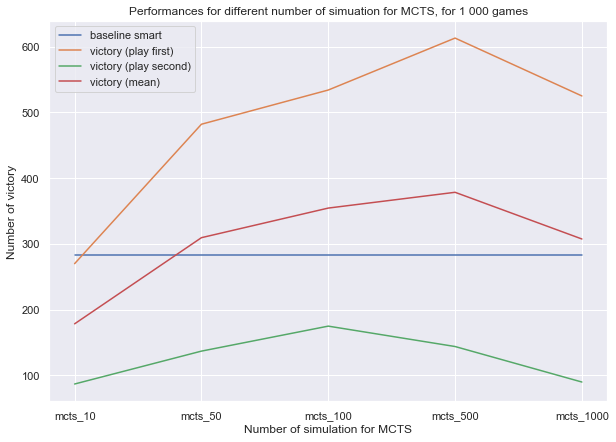

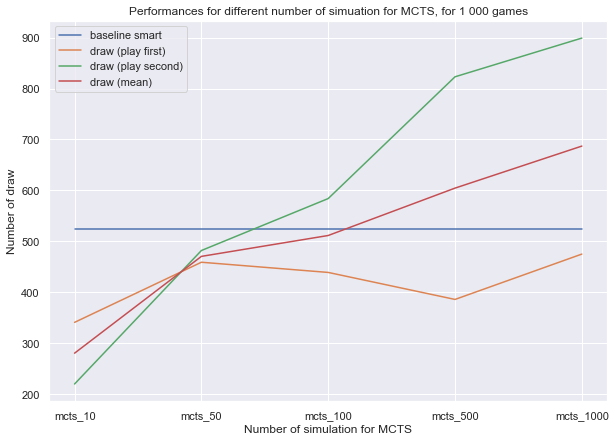

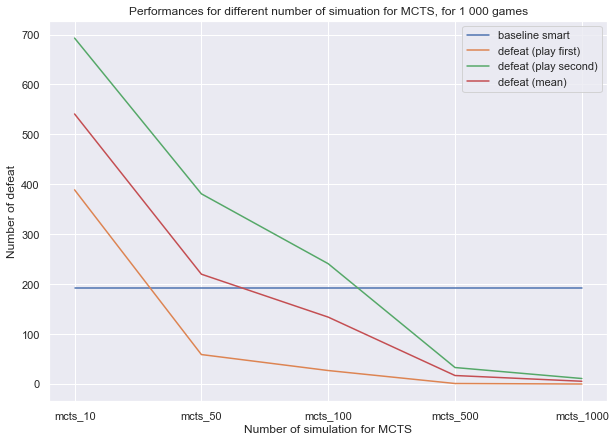

In [22]:
baseline_smart = df_simulations_number[['victory', 'draw', 'defeat']][df_simulations_number['method']=='smart']

idx_smart = df_simulations_number.index[df_simulations_number['method'] == 'smart'].tolist()
df_simulations_number.drop(idx_smart, inplace=True)

df_simulations_number_1 = df_simulations_number[df_simulations_number['play_order']==1]
df_simulations_number_1 = df_simulations_number_1.set_index('method')
df_simulations_number_2 = df_simulations_number[df_simulations_number['play_order']==2]
df_simulations_number_2 = df_simulations_number_2.set_index('method')

for field in ['victory', 'draw', 'defeat']:
    plt.figure(figsize=(10,7))
    plt.plot(df_simulations_number_1.index,
             [baseline_smart[field] for _ in range(len(df_simulations_number_1.index))],
             label='baseline smart')
    plt.plot(df_simulations_number_1.index,
             df_simulations_number_1[field],
             label=field+' (play first)')
    plt.plot(df_simulations_number_2.index,
             df_simulations_number_2[field],
             label=field+' (play second)')
    plt.plot(df_simulations_number_2.index,
             (df_simulations_number_1[field] + df_simulations_number_2[field])/2,
             label=field+' (mean)')
    plt.xlabel('Number of simulation for MCTS')
    plt.ylabel('Number of '+field)
    plt.title('Performances for different number of simuation for MCTS, for 1 000 games')
    plt.legend(loc='best')
    plt.show()

## Importance of the exploration constant

In [72]:
simulations_number = 500

for first_player in [-1, 1]:
    for c_param in [0, 0.2, 0.4, 0.6, 0.8, 1]:
        method = 'mcts_' + str(c_param)
        res_list = []
        for _ in tqdm(range(n_games)):
          res = playTicTacToe(board=None,
                              method_player='mcts',
                              method_computer='smart',
                              first_player=first_player,
                              print_board=False,
                              simulations_number=simulations_number,
                              c_param=c_param)
          res_list.append(res)

        print("Number of games: ", n_games)
        count_res = Counter(res_list)
        print("A smarter player against a 'smart' computer (computer plays first): \n",
              getResultProp(count_res))

        # Save results into csv
        dict_res = getDictResult(counter=count_res,
                                 method=method,
                                 player=1,
                                 first_player=first_player)
        df_exploration = df_exploration.append(dict_res , ignore_index=True)
        df_exploration.to_csv('df_exploration.csv', sep=';')
        if use_drive:
            !cp df_exploration.csv "drive/My Drive/RL/"

  0%|          | 5/1000 [00:09<30:23,  1.83s/it]


KeyboardInterrupt: 

In [95]:
# run to read the csv with results obtained
#df_exploration = pd.read_csv("df_exploration_full.csv", sep=',', index_col=0)
#df_exploration

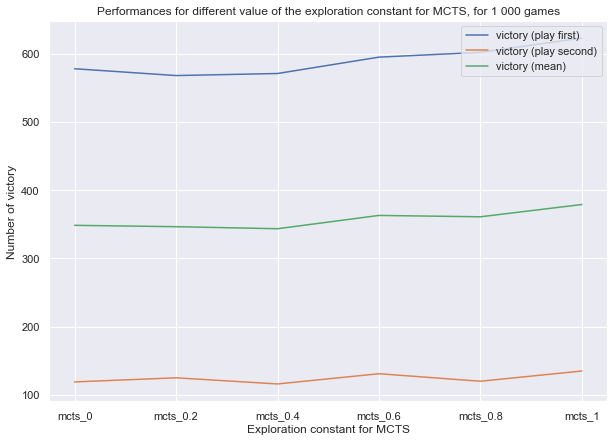

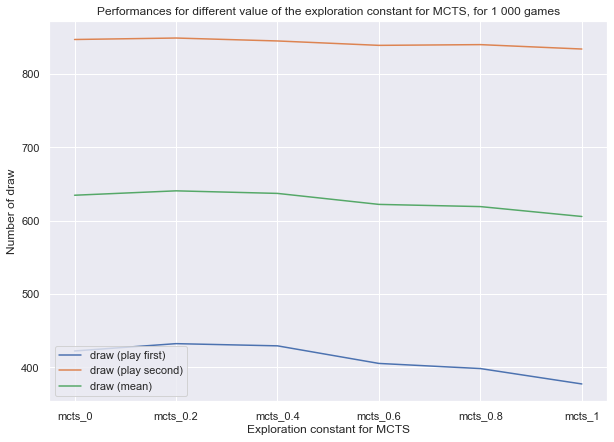

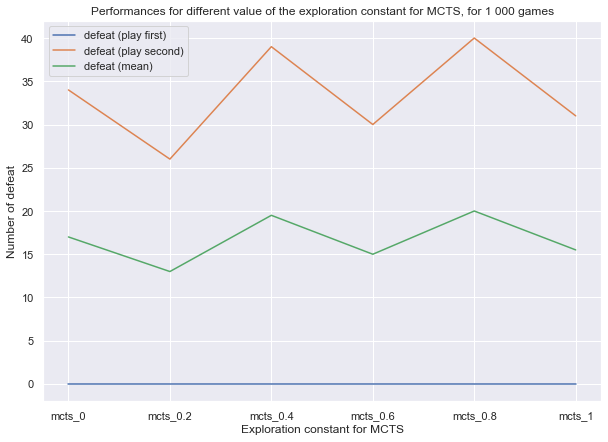

In [96]:
df_exploration_1 = df_exploration[df_exploration['play_order']==1]
df_exploration_1 = df_exploration_1.set_index('method')
df_exploration_2 = df_exploration[df_exploration['play_order']==2]
df_exploration_2 = df_exploration_2.set_index('method')

for field in ['victory', 'draw', 'defeat']:
    plt.figure(figsize=(10,7))
    #plt.plot(df_exploration_1.index,
    #         [baseline_smart[field] for _ in range(len(df_exploration_1.index))],
    #         label='baseline smart')
    plt.plot(df_exploration_1.index,
             df_exploration_1[field],
             label=field+' (play first)')
    plt.plot(df_exploration_2.index,
             df_exploration_2[field],
             label=field+' (play second)')
    plt.plot(df_exploration_2.index,
             (df_exploration_1[field] + df_exploration_2[field])/2,
             label=field+' (mean)')
    plt.xlabel('Exploration constant for MCTS')
    plt.ylabel('Number of '+field)
    plt.title('Performances for different value of the exploration constant for MCTS, for 1 000 games')
    plt.legend(loc='best')
    plt.show()